# Intro to ChromaDB 

In [19]:
import os
import chromadb
import json

import shutil  # ✅ Properly handles folder deletion

import requests
import time


### Step 1: ChromaDB setup
Checking for ChromaDB, creating if its not there

Option to purge DB

In [18]:
# 🔹 CONFIG: Set `purge_db = True` to DELETE & RESET the database
purge_db = False  # Set to True to delete existing DB and start fresh

# ✅ Define ChromaDB path
CHROMA_DB_PATH = "./chroma_db"
COLLECTION_NAME = "news_articles"

# 🔍 Check if ChromaDB exists
if not os.path.exists(CHROMA_DB_PATH):
    print("⚠️ ChromaDB instance not found. Creating a new one...")
    os.makedirs(CHROMA_DB_PATH)
else:
    print("✅ ChromaDB instance found. Using existing database.")

# 🔥 Purge Database If `purge_db` is Enabled
if purge_db:
    print("⚠️ Purging existing ChromaDB...")
    shutil.rmtree(CHROMA_DB_PATH, ignore_errors=True)  # ✅ Remove the directory properly
    os.makedirs(CHROMA_DB_PATH, exist_ok=True)  # ✅ Recreate empty directory
    print("✅ ChromaDB successfully reset.")

# ✅ Reinitialize ChromaDB Client (needed after purge)
client = chromadb.PersistentClient(path=CHROMA_DB_PATH)

# ✅ Recreate Collection If Purged
if purge_db:
    try:
        client.delete_collection(COLLECTION_NAME)  # ✅ Properly delete existing collection
    except Exception:
        pass  # Ignore errors if collection doesn't exist
    collection = client.create_collection(COLLECTION_NAME)  # ✅ Recreate the collection
    print(f"✅ Collection '{COLLECTION_NAME}' recreated after purge.")
else:
    # ✅ Load existing collection
    try:
        collection = client.get_collection(COLLECTION_NAME)
        print(f"✅ Collection '{COLLECTION_NAME}' found.")
    except Exception:
        print(f"⚠️ Collection '{COLLECTION_NAME}' not found. Creating a new one...")
        collection = client.create_collection(COLLECTION_NAME)

print(f"✅ ChromaDB is ready to use.")

✅ ChromaDB instance found. Using existing database.
✅ Collection 'news_articles' found.
✅ ChromaDB is ready to use.


Now to rebuild it using the news.json file

In [ ]:
# ✅ Load articles from news.json
with open("news.json", "r", encoding="utf-8") as f:
    news_articles = json.load(f)

# ✅ Get existing document IDs in ChromaDB (only if NOT purging)
existing_ids = set(collection.get()["ids"]) if not purge_db else set()
print(f"📊 Existing articles in ChromaDB: {len(existing_ids)}")

# ✅ Insert articles (skip duplicates)
new_entries = []
for article in news_articles:
    article_id = article["url"]
    if article_id not in existing_ids:  # Avoid duplicates
        new_entries.append({
            "document": article["content"],
            "metadata": {"title": article["title"], "url": article["url"]},
            "id": article_id
        })

# ✅ Add new articles to ChromaDB
if new_entries:
    collection.add(
        documents=[entry["document"] for entry in new_entries],
        metadatas=[entry["metadata"] for entry in new_entries],
        ids=[entry["id"] for entry in new_entries]
    )
    print(f"✅ {len(new_entries)} new articles added to ChromaDB.")
else:
    print("🔹 No new articles added. Database is up to date.")


✅ ChromaDB instance found. Using existing database.
⚠️ Purging existing ChromaDB...
✅ ChromaDB successfully reset.
✅ Collection 'news_articles' recreated after purge.
✅ ChromaDB is ready to use.
📊 Existing articles in ChromaDB: 0
✅ 49 new articles added to ChromaDB.


### Checking for new articles to add

In [33]:
import json

# ✅ Load articles from news.json
with open("news.json", "r", encoding="utf-8") as f:
    news_articles = json.load(f)

# ✅ Get existing document IDs in ChromaDB (only if NOT purging)
existing_ids = set(collection.get()["ids"]) if not purge_db else set()
print(f"📊 Existing articles in ChromaDB: {len(existing_ids)}")

# ✅ Insert articles (skip duplicates)
new_entries = []
for article in news_articles:
    article_id = article["url"]
    if article_id not in existing_ids:  # Avoid duplicates
        new_entries.append({
            "document": f"{article['title']} {article['content']}",
            "metadata": {
                "title": article.get("title", "Unknown title"),
                "url": article.get("url", "No URL"),
                "published_date": article.get("published_date", "Unknown date"),
                "source_name": article.get("source_name", "Unknown source"),
                "author": article.get("author", "Unknown author"),
                "category": article.get("category", "Unknown category"),
                "content_length": len(article["content"].split()) if article["content"] else 0  # Track content size
            },
            "id": article_id
        })

# ✅ Add new articles to ChromaDB
if new_entries:
    collection.add(
        documents=[entry["document"] for entry in new_entries],  # Stores title + content for retrieval
        metadatas=[entry["metadata"] for entry in new_entries],  # Stores extra metadata
        ids=[entry["id"] for entry in new_entries]
    )
    print(f"✅ {len(new_entries)} new articles added to ChromaDB.")
else:
    print("🔹 No new articles added. Database is up to date.")


📊 Existing articles in ChromaDB: 58
🔹 No new articles added. Database is up to date.


### Testing queries in the ChromaDB

In [23]:
from chromadb import Client

query = "Is democracy going well?"
results = collection.query(query_texts=[query], n_results=3)

for res in results['documents'][0]:
    print("🔹 Retrieved:", res)


🔹 Retrieved: Here are some takeaways from the first month of Trump’s Mideast diplomacy Here are some takeaways from the first month of Trump’s Mideast diplomacy

Here are some takeaways from the first month of Trump’s Mideast diplomacy View Photo

JERUSALEM (AP) — When Hamas threatened to call off the planned release of three Israeli hostages last week, U.S. President Donald Trump stepped into the picture with an unexpected ultimatum.

Speaking in the Oval Office, Trump called on Hamas to release all of the more than 70 hostages it is holding by noon on Saturday. Otherwise, he warned, “all hell is going to break loose.”

“They’ll find out what I mean. Saturday at 12,” Trump declared. Israeli Prime Minister Benjamin Netanyahu, in lockstep with the president, hinted the entire deal could collapse.

Hamas ended up releasing the three hostages as originally planned. Netanyahu freed scores of Palestinian prisoners in return, and Trump’s noon deadline came and went with no further hostage re

### Doing Analysis on the stored values in ChromaDB


 **ChromaDB Article Statistics**
🔹 Total Articles: 50
🔹 Articles with Missing Content: 0
🔹 Average Article Length: 970.42 words
🔹 Max Article Length: 2619 words
🔹 Min Article Length: 24 words


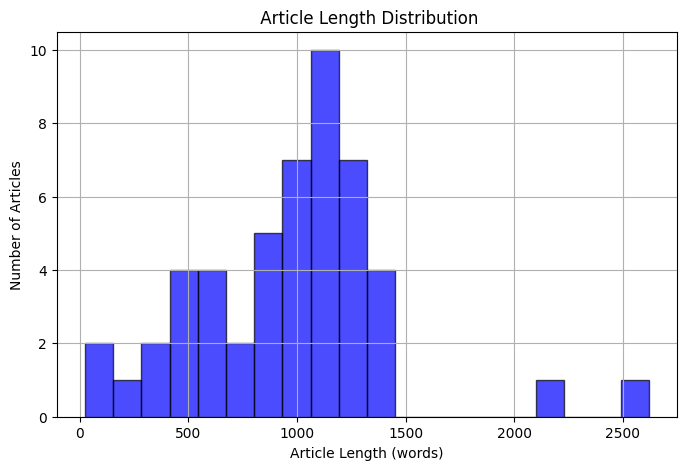


 **Most Common Words in Articles** (Top 10):
🔹 the: 2118 occurrences
🔹 of: 1584 occurrences
🔹 a: 1452 occurrences
🔹 and: 1211 occurrences
🔹 to: 1064 occurrences
🔹 in: 940 occurrences
🔹 on: 720 occurrences
🔹 The: 514 occurrences
🔹 shares: 487 occurrences
🔹 for: 314 occurrences


In [24]:
## NEED TO FIXXXXXX

import chromadb
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# ✅ Initialize ChromaDB Client
CHROMA_DB_PATH = "./chroma_db"
COLLECTION_NAME = "news_articles"

client = chromadb.PersistentClient(path=CHROMA_DB_PATH)
collection = client.get_collection(COLLECTION_NAME)

# ✅ Retrieve all stored articles
data = collection.get()

# ✅ Extract content & metadata
documents = data["documents"]
titles = [meta["title"] for meta in data["metadatas"]]
urls = [meta["url"] for meta in data["metadatas"]]
ids = data["ids"]

# ✅ Basic Stats
total_articles = len(documents)
word_counts = [len(doc.split()) if doc else 0 for doc in documents]  # Word count per article
null_articles = sum(1 for doc in documents if not doc.strip())  # Count of empty articles

# ✅ Print Statistics
print("\n **ChromaDB Article Statistics**")
print(f"🔹 Total Articles: {total_articles}")
print(f"🔹 Articles with Missing Content: {null_articles}")
print(f"🔹 Average Article Length: {np.mean(word_counts):.2f} words")
print(f"🔹 Max Article Length: {np.max(word_counts)} words")
print(f"🔹 Min Article Length: {np.min(word_counts)} words")

# ✅ Plot Word Count Distribution
plt.figure(figsize=(8, 5))
plt.hist(word_counts, bins=20, color="blue", alpha=0.7, edgecolor="black")
plt.xlabel("Article Length (words)")
plt.ylabel("Number of Articles")
plt.title(" Article Length Distribution")
plt.grid(True)
plt.show()

# ✅ Check Most Common Words (Optional)
word_freq = Counter(" ".join(documents).split())
most_common_words = word_freq.most_common(10)
print("\n **Most Common Words in Articles** (Top 10):")
for word, count in most_common_words:
    print(f"🔹 {word}: {count} occurrences")


In [25]:
query = "Did inflation decrease in January?"
results = collection.query(query_texts=[query], n_results=3)

for res in results["documents"][0]:
    print(f"🔹 Retrieved: {res[:300]}...")


🔹 Retrieved: Keppel Ltd. (OTCMKTS:KPELY) Short Interest Down 8.3% in January Keppel Ltd. (OTCMKTS:KPELY - Get Free Report) was the recipient of a large decline in short interest in the month of January. As of January 31st, there was short interest totalling 7,700 shares, a decline of 8.3% from the January 15th t...
🔹 Retrieved: Klabin S.A. (OTCMKTS:KLBAY) Short Interest Update Klabin S.A. (OTCMKTS:KLBAY - Get Free Report) saw a large decline in short interest during the month of January. As of January 31st, there was short interest totalling 1,000 shares, a decline of 9.1% from the January 15th total of 1,100 shares. Based...
🔹 Retrieved: Keppel REIT (OTCMKTS:KREVF) Sees Significant Decline in Short Interest Keppel REIT (OTCMKTS:KREVF - Get Free Report) was the target of a large decrease in short interest in January. As of January 31st, there was short interest totalling 5,980,700 shares, a decrease of 9.5% from the January 15th tota...


In [ ]:
results = collection.query(
    query_texts=["Is inflation increasing?"],
    n_results=3,
    where={"date": {"$gte": "2024-01-01"}}
)


In [ ]:
keyword_results = collection.query(query_texts=["inflation"], n_results=3, where={"title": {"$contains": "inflation"}})
